# GxE problem

- I updated the simulation function so that sigma is always positive (exponential)
- I am adding the decomposition of the effects
- 100 replicates per scenario

### Next steps

- Find specifications where the test would be misleading

In [223]:
library(brms)
library(data.table)
library(texreg)
library(future)
plan(multicore)
source("../src/utils.R")

In [413]:
# scaling model 
simScaling = function(E, a0 = 0, a1 = 0.5, b0 = 0.8, b1 = 0.2, h2 = 0.5) {
    N = length(E)
    G = rnorm(N,0,1)
    h = sqrt(h2)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    eps = rnorm(N, 0, sigma)
    y = a0 + a1*E + b0*h*G + b1*h*E*G + eps
    df = data.frame(E = E, y = y, g = G)
}

# interaction model
simInteraction = function(E, a0 = 0.0, a1 = 0.5, b0 = 0.8, b1 = 0.5, sb0 = 0.4, sb1 = 0.15) {
    N = length(E)
    G = rnorm(N,0,1)
    sigma = exp(sb0 + sb1 * E) 
    eps = rnorm(N, 0, sigma)
    y = a0 + a1*G + b0*E + b1*G*E + eps
    df = data.frame(E = E, y = y, g = G)
}

# interaction + scaling model
simScalingInteraction = function(E, a0 = 0.0,  a1 = 0.5, a2 = 0.10, b0 = 0.8, b1 = 0.2, h2 = 0.5) {
    N = length(E)
    G = rnorm(N,0,1)
    h = sqrt(h2)
    e = sqrt(1-h^2)
    sigma = exp(b0*e + b1*e*E) 
    eps = rnorm(N, 0, sigma)
    y = a0 + a1*E + a2*G*E + b0*h*G + b1*h*E*G + eps
    df = data.frame(E = E, y = y, g = G)
}

# domingue's original function
simDom = function(E,b0 = .8, b1 = .2, b2 = 0, b3 = .05, h = sqrt(.6), a =.5, sigma = 1, scaling = TRUE) {
    N = length(E)
    G = rnorm(N,0,1)
    eps = rnorm(N,0,sigma)
    if (scaling){
        e = sqrt(1-h^2)
        ystar = h*G+e*eps
        y = a*E+(b0 + b1*E)*ystar
    } else {
        y = b1*G+b2*E+b3*G*E+eps
    }
    df = data.frame(E=E,y=y,g=G)
}

# decomposition function
decompR = function(model) {
    s = posterior_samples(model)
    names(s) = tolower(names(s))
    l0 = s[["b_sigma_intercept"]]
    l1 = s[["b_sigma_e"]]
    p0 = s[["b_g"]]
    p1 = s[["b_g:e"]]
    v =  ( (l0*p1 - l1*p0)/l0 ) / p1
}

## Simulating data

In [414]:
E = rnorm(5000, 0, 1)
replicates = 30
dts = replicate(replicates, simScaling(E), simplify = FALSE)
dti = replicate(replicates, simInteraction(E), simplify = FALSE)
dtsi = replicate(replicates, simScalingInteraction(E), simplify = FALSE)
dom = replicate(replicates, simDom(E, scaling = TRUE), simplify = FALSE)

In [415]:
cnames = c("Scaling", "Interaction", "Scaling + Interaction", "Domingue's simulation")
models = list()
models[[1]] = lm(y ~ g + E + g * E, data = dts[[1]])
models[[2]] = lm(y ~ g + E + g * E, data = dti[[1]])
models[[3]] = lm(y ~ g + E + g * E, data = dtsi[[1]])
models[[4]] = lm(y ~ g + E + g * E, data = dom[[1]])
cat(screenreg(models, custom.model.names = cnames))


             Scaling      Interaction  Scaling + Interaction  Domingue's simulation
-----------------------------------------------------------------------------------
(Intercept)     0.01        -0.04        -0.01                  -0.00              
               (0.03)       (0.02)       (0.03)                 (0.01)             
g               0.58 ***     0.46 ***     0.61 ***               0.61 ***          
               (0.03)       (0.02)       (0.03)                 (0.01)             
E               0.47 ***     0.77 ***     0.53 ***               0.50 ***          
               (0.02)       (0.02)       (0.02)                 (0.01)             
g:E             0.14 ***     0.51 ***     0.23 ***               0.14 ***          
               (0.03)       (0.02)       (0.03)                 (0.01)             
-----------------------------------------------------------------------------------
R^2             0.15         0.31         0.18                   0.70      


# Bayesian distributional model


In [ ]:
# distributional model using bayesian stats
f = bf(y ~ g + E + g * E, sigma ~ 1 + E)
b1 = brm_multiple(f, data = dts, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b2 = brm_multiple(f, data = dti, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b3 = brm_multiple(f, data = dtsi, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)
b4 = brm_multiple(f, data = dom, family = brmsfamily("gaussian", link_sigma = "log"), chains = 1)

In [417]:
# checking convergence of models
rb1 = unlist(b1$rhats)
rb2 = unlist(b2$rhats)
rb3 = unlist(b3$rhats)
rb4 = unlist(b4$rhats)
print(table(rb1 > 1.05 | rb1 < 0.95))
print(table(rb2 > 1.05 | rb2 < 0.95))
print(table(rb3 > 1.05 | rb3 < 0.95))
print(table(rb4 > 1.05 | rb4 < 0.95))


FALSE 
  210 

FALSE 
  210 

FALSE 
  210 

FALSE 
  210 


In [418]:
# able to recover the correct sigma coefficients 
suppressWarnings(cat(screenreg(list(b1, b2, b3, b4), custom.model.names = cnames, 
    use.HDI = TRUE,
    include.rsquared = TRUE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    include.waic = FALSE)))


                 Scaling        Interaction    Scaling + Interaction  Domingue's simulation
-------------------------------------------------------------------------------------------
Intercept           0.01           0.00          -0.01                  -0.00              
                 [-0.05; 0.06]  [-0.04; 0.05]  [-0.06; 0.05]          [-0.02;  0.02]       
sigma_Intercept     0.57 *         0.40 *         0.56 *                -0.71 *            
                 [ 0.54; 0.59]  [ 0.38; 0.42]  [ 0.54; 0.59]          [-0.74; -0.69]       
g                   0.57 *         0.50 *         0.57 *                 0.62 *            
                 [ 0.52; 0.63]  [ 0.45; 0.54]  [ 0.51; 0.63]          [ 0.60;  0.63]       
E                   0.50 *         0.80 *         0.50 *                 0.50 *            
                 [ 0.44; 0.55]  [ 0.75; 0.84]  [ 0.44; 0.56]          [ 0.49;  0.51]       
g:E                 0.14 *         0.51 *         0.24 *                 0.15 *

# Tests

## Scaling

In [430]:
# I cannot reject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b1, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0        0      0.02    -0.04     0.04         NA
  Post.Prob Star
1        NA     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

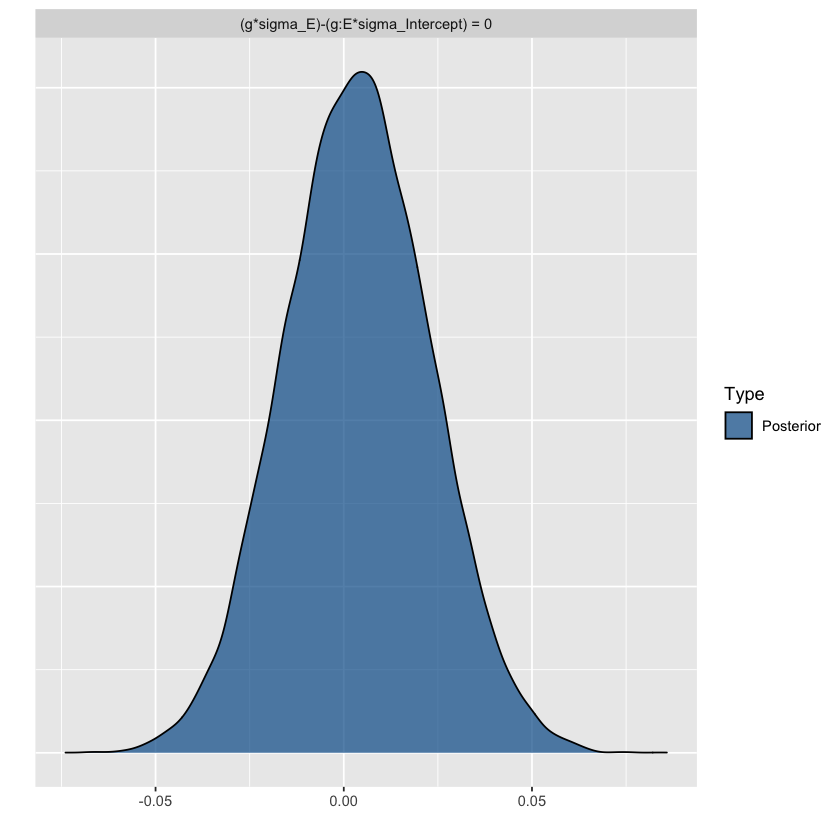

In [352]:
plot(hyp)

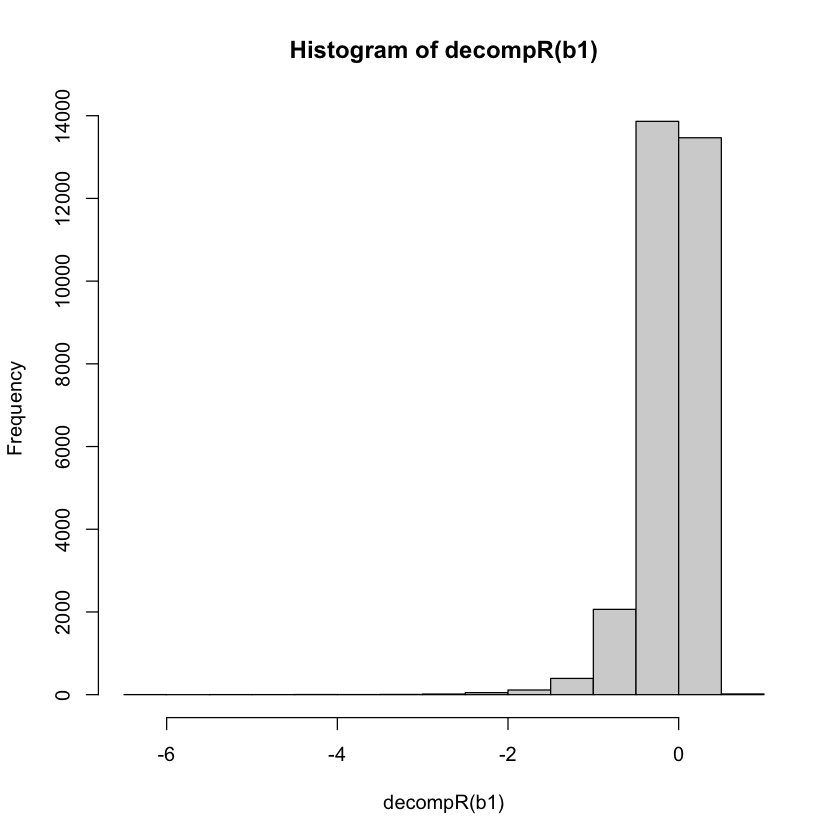

In [431]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(b1))

## Interaction

In [432]:
# I reject the null hypothesis
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b2, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0    -0.13      0.01    -0.15     -0.1         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

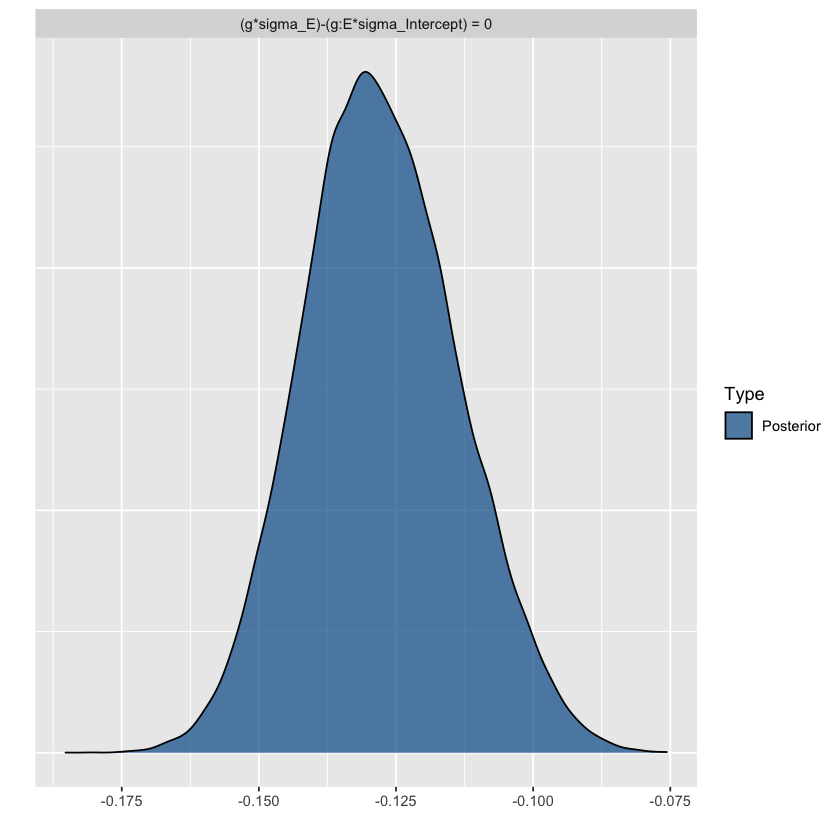

In [433]:
plot(hyp)

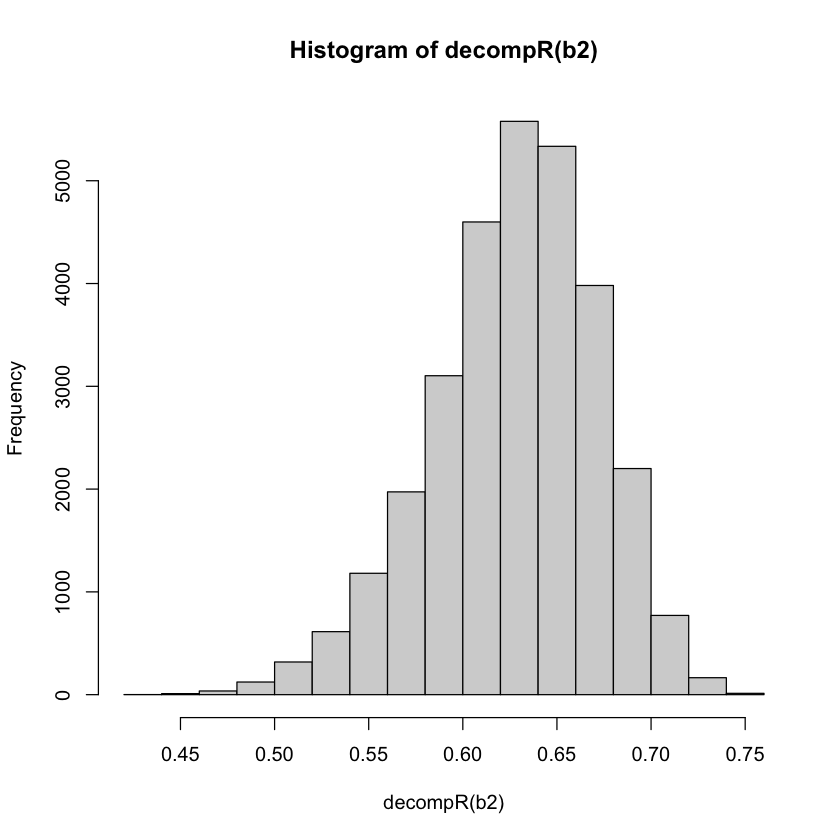

In [434]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(b2))

## Interaction + Scaling

In [435]:
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b3, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0    -0.06      0.02    -0.09    -0.01         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

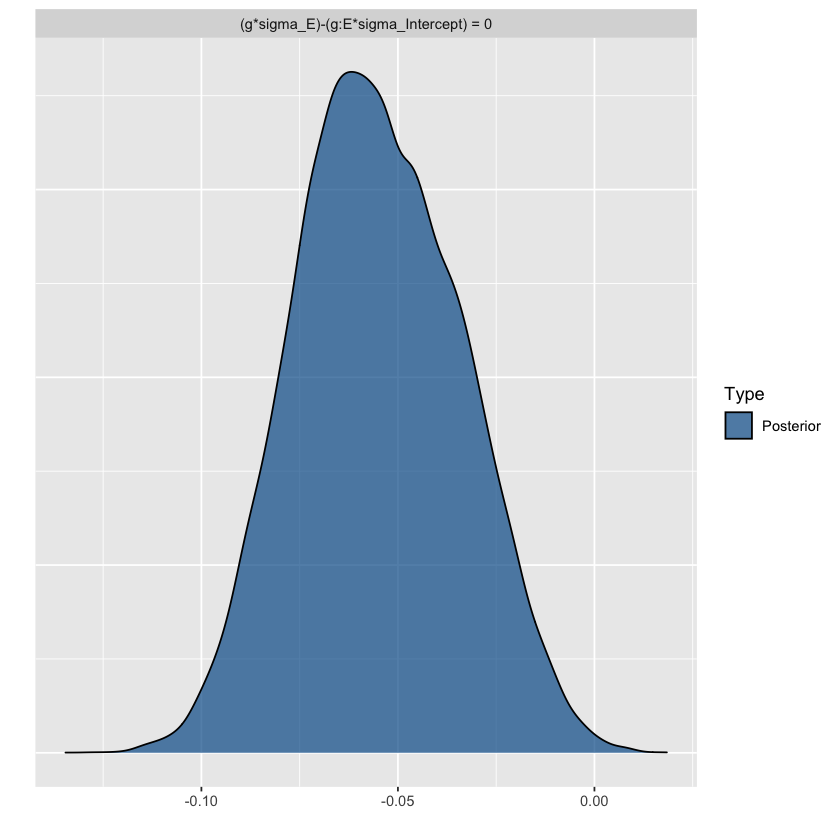

In [436]:
plot(hyp)

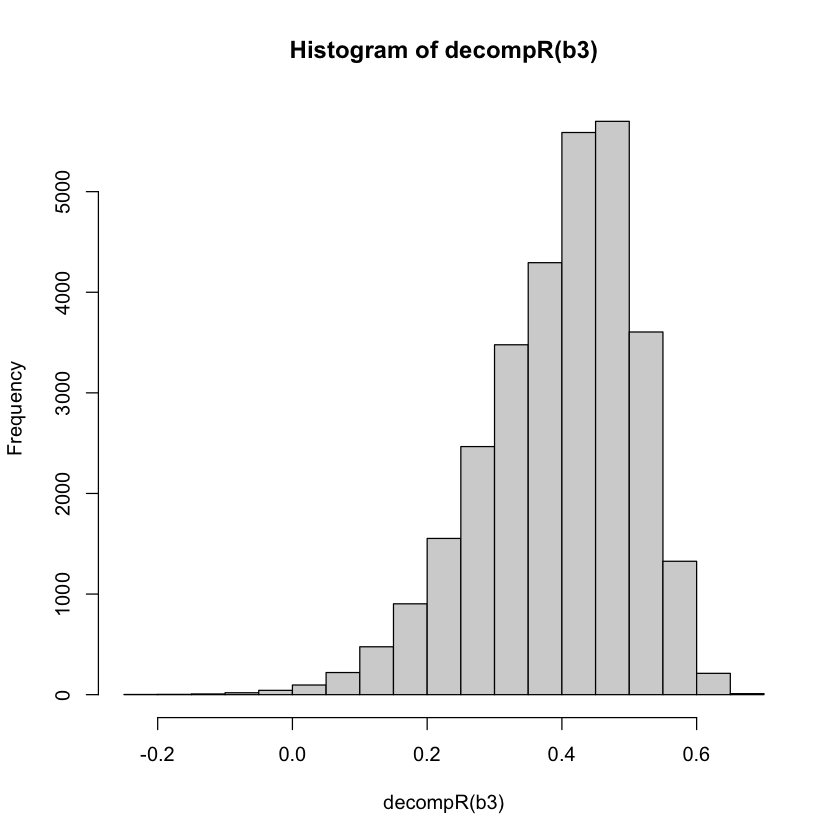

In [437]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(b3))

# Domingue's simulation

In [364]:
# wrong test
hyp <- "g * sigma_E = g:E * sigma_Intercept"
(hyp <- hypothesis(b4, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (g*sigma_E)-(g:E*... = 0     0.28      0.01     0.25      0.3         NA
  Post.Prob Star
1        NA    *
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

# A more complex heritability function

$$ V_P = V_G + V_E + Cov(V_G, V_E) + V_{HD}$$

- G = Genetic info
- E = Enviroment
- HD = Developmental noise

In [438]:
# simulation variables
simComplexH = function(E, a = 0.0, a1 = 0.5, b0 = 0.3, b1 = 0.2, 
    hg = 0.3, he = 0.3, hge = 0.2, print = FALSE) {
    
    n = length(E)
    G = rnorm(n)

    hd = 1 - (hg + he + hge)
    if (print) print(paste0("Total sum of coefficients: ", sum(hg, he, hge, hd)))   

    hg = sqrt(hg)
    he = sqrt(he)
    hge = sqrt(hge)
    hd = sqrt(hd)
    
    ys = hg * G + he * E + hge * G * E

    if (print) {
    
    print(paste0("Sigma intercept: ", b0*hd))
    print(paste0("Sigma slope: ", b1 * hd))
    }
    
    sigma = exp(b0 * hd  + b1 * hd * E)
    eps = rnorm(n, 0, sigma)
    y = a + a1 * E + (b0 + b1 * E) * ys + eps
    #y = a + (b0 + b1 * E) * ys + eps
    dat = data.table(y, G, E)
}

In [439]:
E = rnorm(5000)
dd = replicate(10, simComplexH(E), simplify = FALSE)

In [440]:
cat(screenreg(list( 
    lm(y ~ G + E + E*G, data = dd[[1]]))))


             Model 1    
------------------------
(Intercept)     0.10 ***
               (0.02)   
G               0.29 ***
               (0.02)   
E               0.67 ***
               (0.02)   
G:E             0.26 ***
               (0.02)   
------------------------
R^2             0.30    
Adj. R^2        0.30    
Num. obs.    5000       
*** p < 0.001; ** p < 0.01; * p < 0.05


In [ ]:
f = bf(y ~ G + E + E * G, sigma ~ E)
test = brm_multiple(f, data = dd)

In [442]:
suppressWarnings(cat(screenreg(test, 
    include.rsquared = FALSE,
    include.nobs = TRUE,
    include.loo.ic = FALSE,
    reloo = FALSE,
    include.waic = FALSE)))


                 Model 1     
-----------------------------
Intercept           0.11 *   
                 [0.08; 0.15]
sigma_Intercept     0.16 *   
                 [0.13; 0.18]
G                   0.25 *   
                 [0.21; 0.30]
E                   0.62 *   
                 [0.58; 0.66]
G:E                 0.21 *   
                 [0.18; 0.24]
sigma_E             0.08 *   
                 [0.06; 0.11]
-----------------------------
Num. obs.        5000        
* 0 outside the confidence interval.


In [446]:
hyp <- "G * sigma_E = G:E * sigma_Intercept"
(hyp <- hypothesis(test, hyp, alpha = 0.05))

Hypothesis Tests for class b:
                Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (G*sigma_E)-(G:E*... = 0    -0.01      0.01    -0.02        0         NA
  Post.Prob Star
1        NA     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

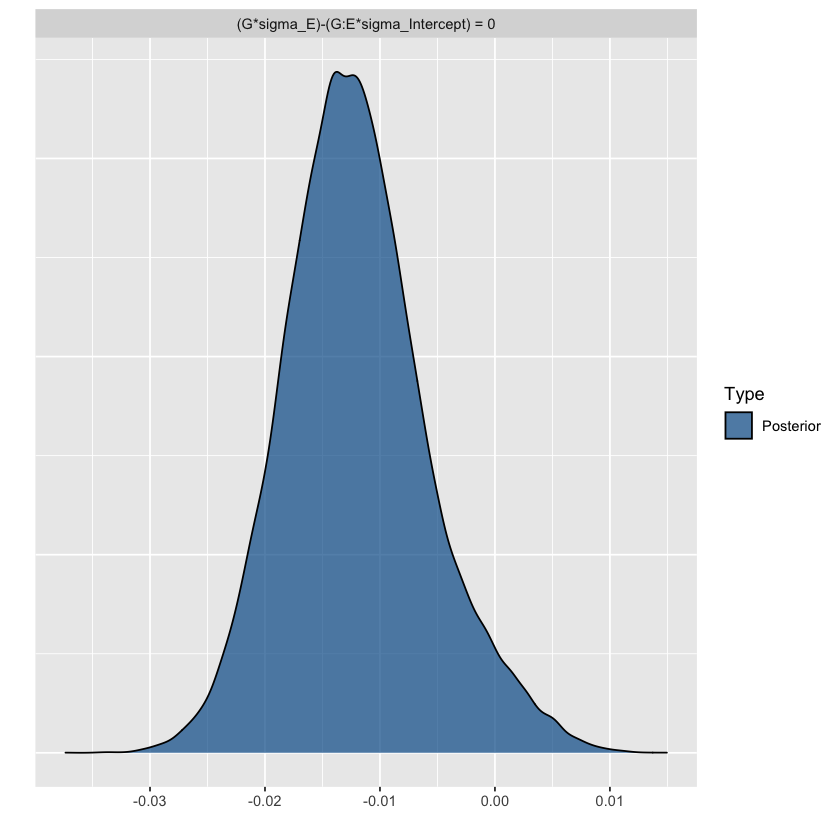

In [447]:
plot(hyp)

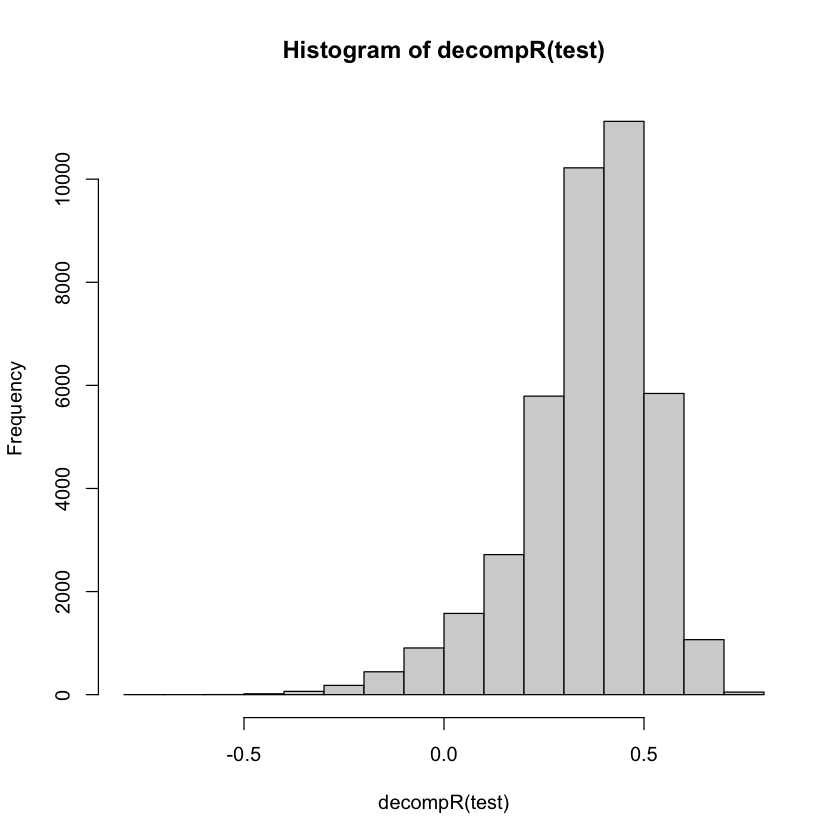

In [449]:
# magnitude of the departure from the scaling model as a proportion of the total GxE effect
hist(decompR(test))